<a href="https://colab.research.google.com/github/sapto-nugroho/PCD/blob/main/PCD_Assignment01/PCD_Assignment01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#
##Nama  : Sapto Nugroho
##NIU   : 565712

In [2]:
!ls
!git clone https://github.com/sapto-nugroho/PCD.git
!ls

PCD  sample_data
fatal: destination path 'PCD' already exists and is not an empty directory.
PCD  sample_data


###Import

In [4]:
import cv2
import pandas as pd
import numpy as np
# import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

###Image Acquisition

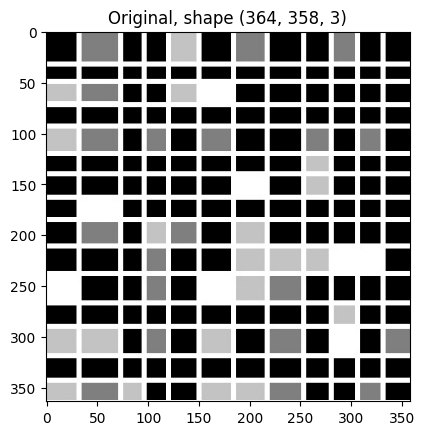

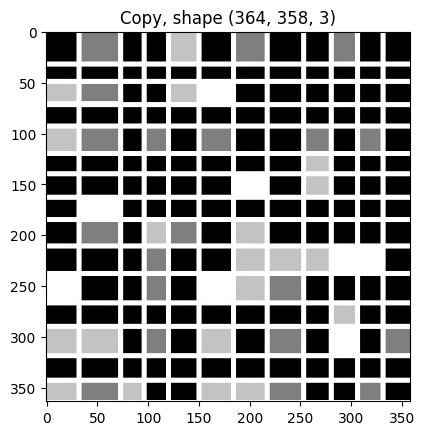

In [13]:
#Image
img_path = '/content/PCD/PCD_Assignment01/grid.jpg'
img = plt.imread(img_path)
plt.figure()
plt.title(f"Original, shape {img.shape}")
plt.imshow(img)
# print(img)

#Image Copy
img_copy = img.copy()
plt.figure()
plt.title(f"Copy, shape {img_copy.shape}")
plt.imshow(img_copy)
# print(img02_copy)


###Downsampling

In [22]:
div = 2**3

#baris
baris = img_copy.shape[0]//div
print(f"baris = {baris}, sisa baris = {img_copy.shape[0]%div}")

#kolom
kolom = img_copy.shape[1]//div
print(f"kolom = {kolom}, sisa kolom = {img_copy.shape[1]%div}")

#wadah Matriks DownSample (MDS)
MDS = np.zeros(shape=(baris,kolom,3),dtype=np.uint8)
print(img_copy.shape,"==>",MDS.shape)
#print(MDS)

#DownSampling
for j in range(0,MDS.shape[0]):
  # print("J= ",j,j*div)
  for i in range(0,MDS.shape[1]):
    # print(i, i*div)
    MDS[j][i] = img_copy[j*div][i*div]

baris = 45, sisa baris = 4
kolom = 44, sisa kolom = 6
(364, 358, 3) ==> (45, 44, 3)


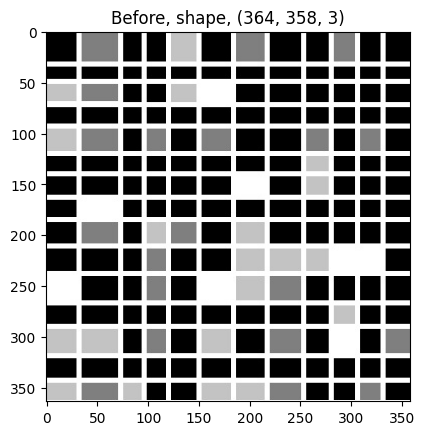

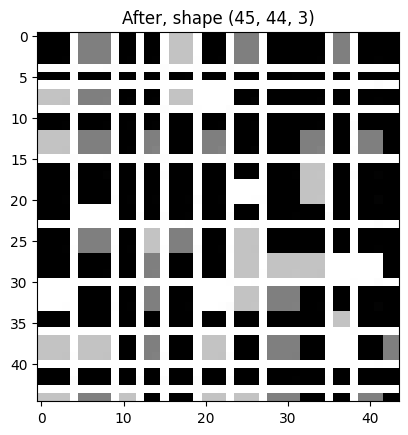

In [20]:
plt.figure()
plt.imshow(img_copy)
plt.title(f"Before, shape, {img_copy.shape}")
plt.figure()
plt.title(f"After, shape {MDS.shape}")
plt.imshow(MDS)

In [ ]:
# print(img02_copy[-1][-1])
print(MDS)
print("===============================")
M = np.array([1,2,3])
print(M.shape)
print(M)
M = M.reshape(1,3)
print(M.shape)
print(M)
print("===============================")
print(MDS[0].shape)
# MDS = np.append(M_DS,M)
MDS[0] = np.concatenate((MDS[0],M),axis=1)
# C = np.concatenate((M,MDS[0][0]),axis=0)
print(MDS[0][0].shape)
print(MDS)


In [ ]:
# pd.Series(img01.flatten()).plot(kind="hist",
#                                bins=25,
#                                title='Pixel Values')
# plt.show()

flat = img02.flatten()
# print(flat.shape)
# print(flat)

A = []

for i in range(len(flat)):
  if i%3==0:
    A.append(int(flat[i]))

A = np.array(A)
print(A[0].dtype)

# pd.Series(img02.flatten()).plot(kind="hist",
#                                bins=25,
#                                title='Pixel Values')
# plt.show()

int64


##junk

In [ ]:
# img2 = mpimg.imread(img02_path)
# plt.imshow(img2)
# plt.axis('off')
# plt.show()

In [ ]:
A = np.zeros( (2, 3, 5) )
print("A = {}\n".format(A))
## 1rst term => depth
## 2 other terms => (i,j)

## basic 2D array
B = np.ones( (1,3, 5) )
print("B = {}\n".format(B))

## 2D array reshaped into 3D one prior to be concatenated
# Bprime = B.reshape(1,3,5)
# print("Bprime = {}\n".format(Bprime))

## C is created and suppoed to be A expanded by B
# C = np.concatenate( (A, Bprime) )
C = np.concatenate( (A, B), axis = 0)
print("C = {}\n".format(C))

A = [[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]

B = [[[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]]

C = [[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]]



In [ ]:
# length = len(flat)/3
# length = int(length)

# empty02 = np.zeros(shape=(length),dtype=np.uint8)
# print(empty02)